# Hackathon Challenge MDW2024 Emotion Detection

### Objective
Assign the most dominant emotion to each tweet, in particular:

- 0 -> Angry 
- 1 -> Joy  
- 2 -> Sadness  
- 3 -> Optimism  

## Importing Libraries

In the README.txt file there is a pip command to install all of them

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
import re

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from textstat import flesch_reading_ease

In [23]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Utility Functions

We created some utility functions for cleaning and preprocessing the data:  

- read_txt: Open txt files and import them as DataFrame
- negation_abbreviated_to_standard: Convert words like "aren't" in "are not"
- replace_slang: Convert english slang words in standard words
- preprocess_txt: Tokenize words and converts words into lower case
- clean_txt: Removes URLs, User mentions, Symbol Hashtags, Punctuation and "im" from a tweet

In [2]:
def read_txt(file_dir: str, filename: str, delimiter: str=None, columns: list=None) -> pd.DataFrame:
    filename = filename if ".txt" in filename else filename+".txt"
    return pd.read_csv(os.path.join(file_dir, filename), delimiter=delimiter, header=None, engine="python", names=columns)

stop_words = set(stopwords.words('english'))

re_negation = re.compile("n't ") 

def negation_abbreviated_to_standard(sent):
    sent = re_negation.sub(" not ", sent)
    return sent

slang_dict = {
    "lol": "laughing out loud",
    "lmao": "laughing my ass off",
    "rofl": "rolling on the floor laughing",
    "brb": "be right back",
    "btw": "by the way",
    "imo": "in my opinion",
    "tbh": "to be honest",
    "ttyl": "talk to you later",
    "afaik": "as far as I know",
    "omg": "oh my god",
    "wtf": "what the f***",
    "smh": "shaking my head",
    "jk": "just kidding",
    "np": "no problem",
    "ty": "thank you",
    "pls": "please",
    "gtg": "got to go",
    "gonna": "going to",
    "wanna": "want to",
    "kinda": "kind of",
    "gotta": "got to",
    "sup": "what's up",
    "yas": "yes",
    "bae": "before anyone else/baby/boyfriend/girlfriend",
    "ily": "I love you",
    "nvm": "nevermind",
    "rn": "right now",
    "cray": "crazy",
    "wyd": "what are you doing?",
    "lmk": "let me know",
    "dm": "direct message",
    "irl": "in real life",
    "rt": "retweet",
    "lit": "exciting",
    "salty": "angry",
    "savage": "cool, impressive",
    "feels": "emotions, feelings",
    "mad": "angry, upset",
    "sad boi hours": "feeling sad and melancholic",
    "blessed": "fortunate, happy",
    "shook": "surprised, shocked",
    "whew": "relief, exhaustion",
    "oof": "ouch, unfortunate",
    "rip": "rest in peace/ruined/gone wrong",
    "dead": "hilarious, extremely funny",
    "triggered": "easily upset or offended",
    "hashtag": "#",
    "mention": "@username",
    "tweetstorm": "a series of connected tweets",
    "stan": "to be an extremely devoted fan",
    "flex": "to show off",
}

def replace_slang(text, slang_dict):
    for slang, standard in slang_dict.items():
        text = text.replace(slang, standard)
    return text

def preprocess_txt(text):
    tokens = word_tokenize(text.lower(), language='english')
    # tokens = text.split()
    # lemmatizer = WordNetLemmatizer()
    # tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words and word != "im"]
    return tokens

def clean_txt(tweet):
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet)
    tweet = re.sub(r"@\w+", "", tweet)
    tweet = re.sub(r"#(\w+)", r"\1", tweet)
    tweet = re.sub(r"[^\w\s]", "", tweet)
    tweet = tweet.lower()
    tweet = re.sub(r"\bim\b", "", tweet)
    return tweet

Loading all txt files we need for the predictions. (Change FILE_DIRECTORY with the name of your folder where the files are located)

In [24]:
FILE_DIRECTORY = "MDW2024_Docs_Players"

In [3]:
mapping = read_txt(FILE_DIRECTORY, "mapping", delimiter=r"\s+", columns=['index', 'sentiment'])
mapping = {row[0]: row[1].sentiment for row in mapping.iterrows()}

In [4]:
train_text = read_txt(FILE_DIRECTORY, "train_text", delimiter=r"\n", columns=["text"])
train_labels = read_txt(FILE_DIRECTORY, "train_labels", delimiter=r"\n", columns=["sentiment"])

val_text = read_txt(FILE_DIRECTORY, "val_text", delimiter=r"\n", columns=["text"])
val_labels = read_txt(FILE_DIRECTORY, "val_labels", delimiter=r"\n", columns=["sentiment"])

## Data Cleaning

First we are going to clean each tweet. Then we tokenize each row and remove all the stop words (we are using standard english file for stop words)

In [5]:
train_text["clean_text"] = train_text["text"].apply(clean_txt)
val_text["clean_text"] = val_text["text"].apply(clean_txt)

train_text['tokens'] = train_text['clean_text'].apply(preprocess_txt)
val_text['tokens'] = val_text['clean_text'].apply(preprocess_txt)

# Data Exploration

An interesting thing to see is how many words there are by sentiment. Maybe sad tweet are short while optimism tweet are long because there is some aphorisms.

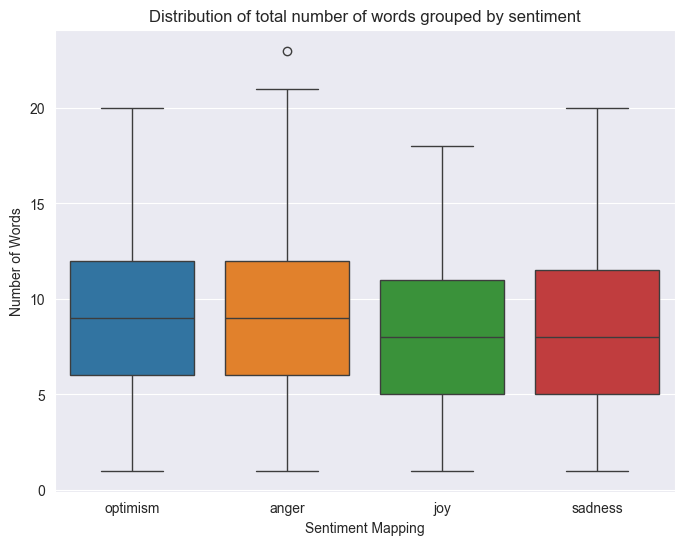

In [6]:
train_text['totword'] = train_text['tokens'].apply(len)
train_text['sentiment'] = train_labels['sentiment'].map(mapping)

plt.figure(figsize=(8,6))
sns.boxplot(x='sentiment', y='totword', data=train_text, palette=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], hue='sentiment', legend=False)
plt.xlabel('Sentiment Mapping')
plt.ylabel('Number of Words')
plt.title('Distribution of total number of words grouped by sentiment')
plt.show()

We notice some asymmetric behaviour, moreover the distributions are almost similar, so the feature of the number of words is not so relevant to distinguish the classes.

Now let's analyze a feature similar to the previous one: number of chars per sentences

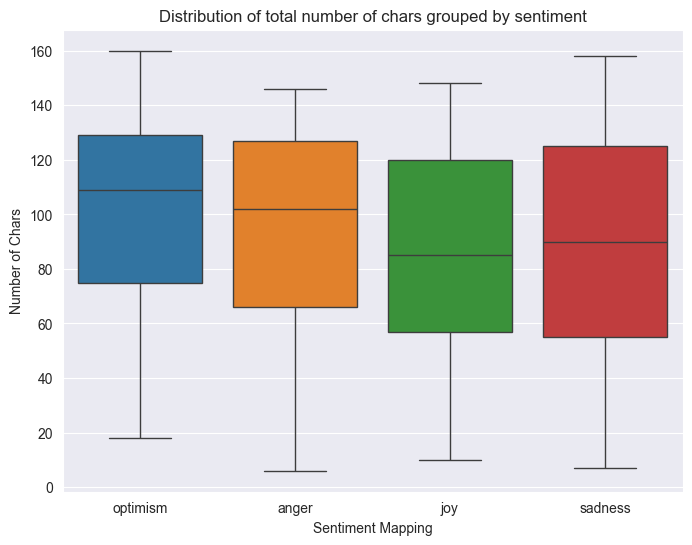

In [7]:
train_text['n_chars'] = train_text['text'].apply(len)

plt.figure(figsize=(8, 6))
sns.boxplot(x='sentiment', y='n_chars', data=train_text, palette=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], hue='sentiment', legend=False)
plt.xlabel('Sentiment Mapping')
plt.ylabel('Number of Chars')
plt.title('Distribution of total number of chars grouped by sentiment')
plt.show()

Here there are the distributions are more asymmetric than the previous plots, but again not so such difference as to distinguish any particular classes.

From the last two graphs, we can see some uniformity among the different classes, which we will explore in detail by examining the number of texts per class.

<Figure size 800x600 with 0 Axes>

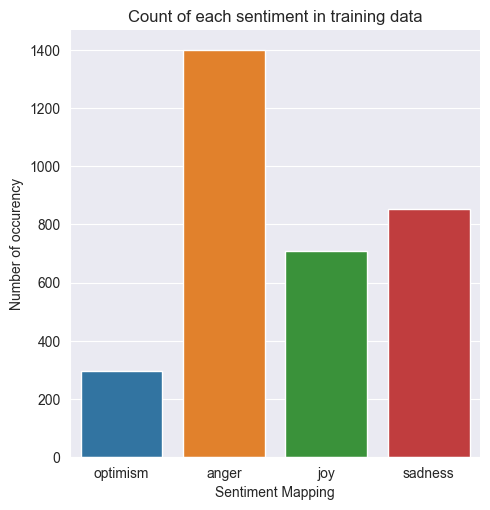

In [8]:
sentiment_mapped = pd.DataFrame(train_labels["sentiment"].map(mapping))

plt.figure(figsize=(8, 6))
sns.catplot(data=sentiment_mapped, x='sentiment', kind='count', palette=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], hue='sentiment',)
plt.title("Count of each sentiment in training data")
plt.xlabel("Sentiment Mapping")
plt.ylabel("Number of occurency")
plt.show()

Here the first difference appears. The numerosity of each class is different. We notice the majority presence of “anger” over the others. In fact, it is known that the majority of tweets are flame. In contrast, the optimistic tweets are those present in the smallest proportion.

Now we look for the top occured words for each sentiment.

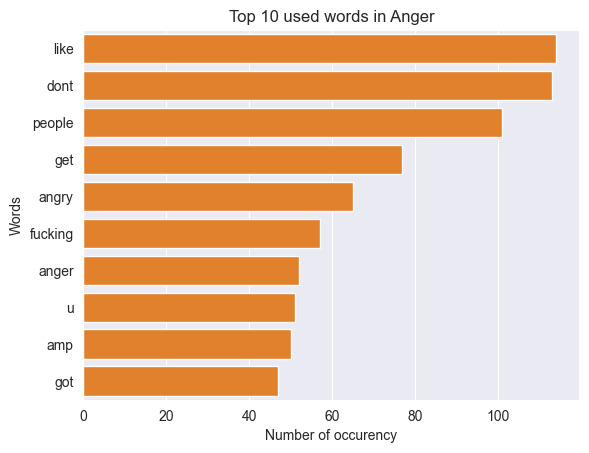

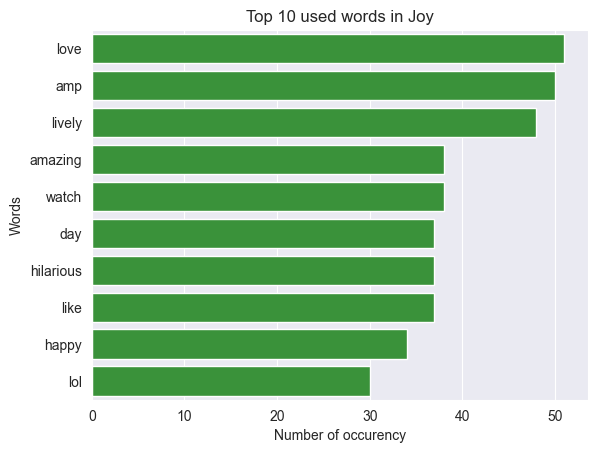

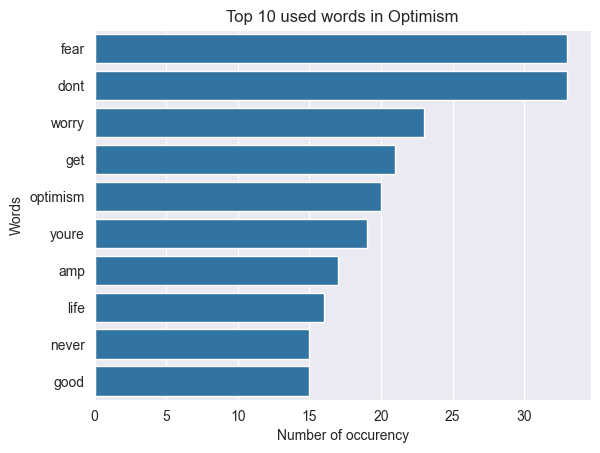

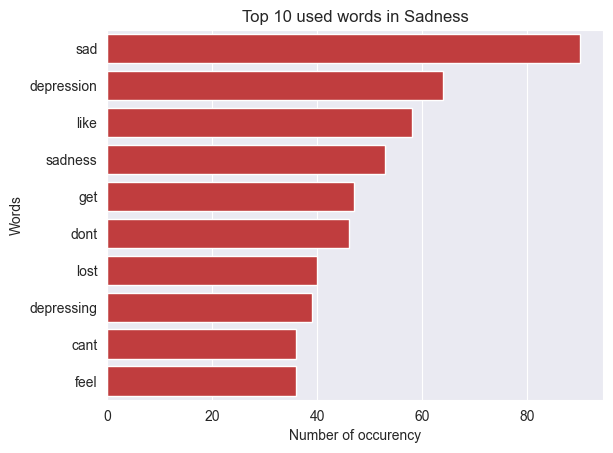

In [9]:
most_common_words = {}
palette = {"optimism": '#1f77b4', "anger": '#ff7f0e', "joy": '#2ca02c', "sadness": '#d62728'}
top_n = 10   

for sentiment in mapping.keys():
    sentiment_tokens = train_text[train_labels['sentiment'] == sentiment]['tokens']
    word_counts = Counter()

    for tokens in sentiment_tokens:
        word_counts.update(tokens)

    most_common_words[mapping[sentiment]] = word_counts.most_common(10)
            
        
for sentiment, words in most_common_words.items():
    df = pd.DataFrame(words, columns=['word', 'n'])

    sns.barplot(x='n', y='word', data=df, hue='word', palette=[palette[sentiment]] * top_n)
    
    plt.xlabel('Number of occurency')
    plt.ylabel('Words')
    plt.title(f'Top {top_n} used words in {sentiment.capitalize()}')
    
    plt.show()

We noticed that the word "im" was the most in the list. So we went back to the "preprocess_txt" function and decided to remove it before tokenization. A simple choice but influential in the final macro avg F1 score. 

### TF-IDF

The TF-IDF function is used to evaluate the importance of a term in a document relative to a collection of documents. It increases proportionally with the frequency of the term in the document, while decreasing with its frequency in the collection, highlighting terms that are common in a document but rare in the collection.

#### First we analyze tf-idf of a single monogram 

In [10]:
def get_top_tfidf_words(tfidf_df, sentiment, top_n=10):
    group_df = tfidf_df[tfidf_df['sentiment'] == sentiment].drop(['sentiment'], axis=1)
    max_tfidf = group_df.max().sort_values(ascending=False).head(top_n)
    return max_tfidf.reset_index().rename(columns={'index': 'word', 0: 'tf_idf'})

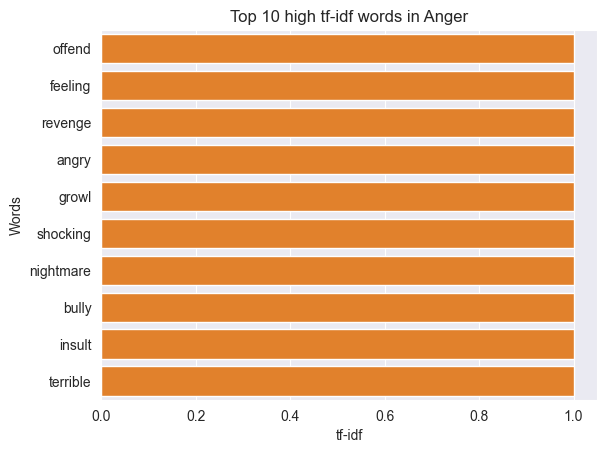

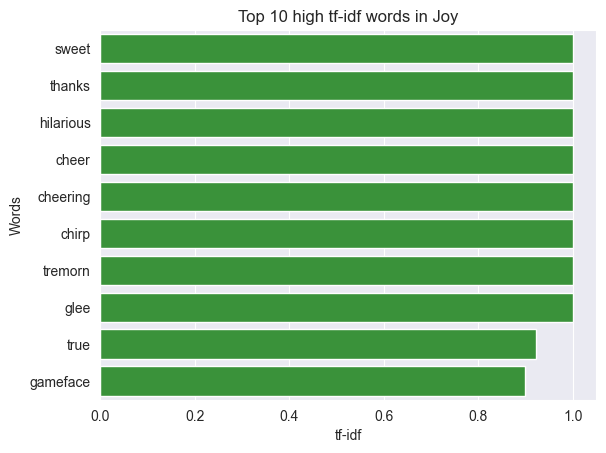

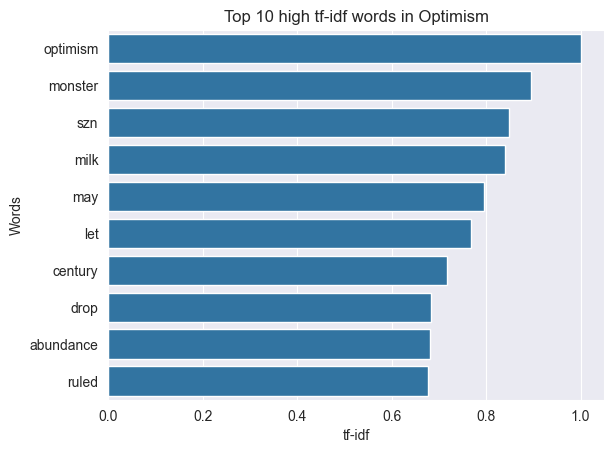

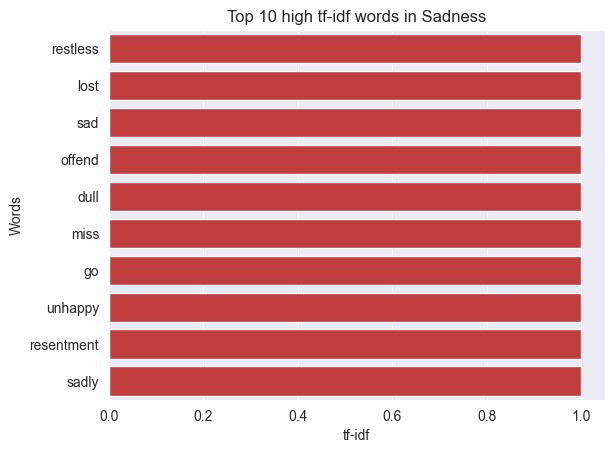

In [11]:
train_text['tokens_clean'] = train_text['tokens'].apply(lambda tokens: ' '.join(tokens))

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(train_text['tokens_clean'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df['sentiment'] = train_labels["sentiment"]

most_common_words_tfidf = {}
top_n= 10
for sentiment in mapping.keys():
    sentiment_tokens = train_text[train_labels['sentiment'] == sentiment]['tokens_clean']
    
    top10_tfidf = get_top_tfidf_words(tfidf_df, sentiment, top_n=top_n)

    most_common_words_tfidf[mapping[sentiment]] = top10_tfidf
        
for sentiment, df in most_common_words_tfidf.items():
    sns.barplot(x='tf_idf', y='word', data=df, hue='word', palette=[palette[sentiment]] * top_n)
    
    plt.xlabel('tf-idf')
    plt.ylabel('Words')
    plt.title(f'Top {top_n} high tf-idf words in {sentiment.capitalize()}')
    
    plt.show()

Compared with the analysis of the most frequently occurring words, in which however the link between words and the realtive sentiment was evident, here we notice more pregnant words: more adjectives and fewer verbs. Some words are shared among the various classes, but these are common words and there are very few of them.

#### Then we analyze tf-idf of bigram 

We noticed that verbs are more frequent in the top occured words, while adjectives are more prevalent once applied the TF-IDF analysis. To capture meaning more effectively, we could consider group of two words. This way we may get couple of verb-adjective to capture meaning more effectively.

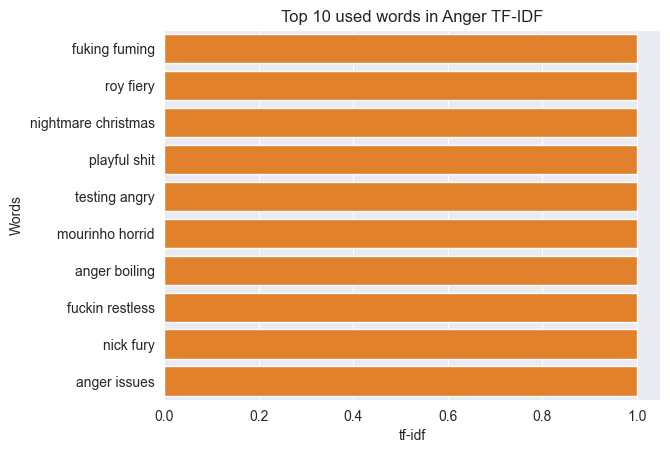

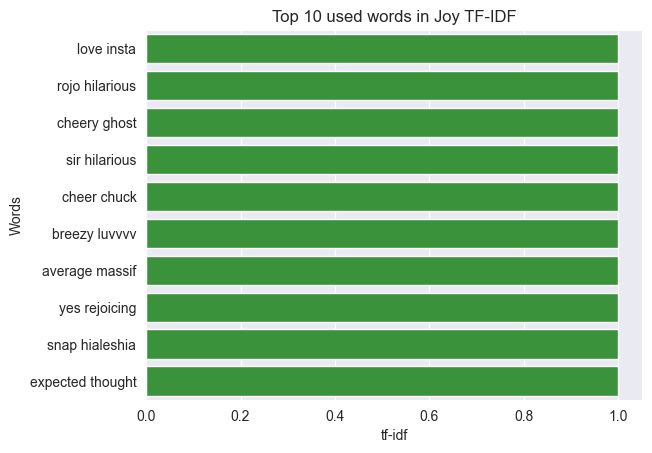

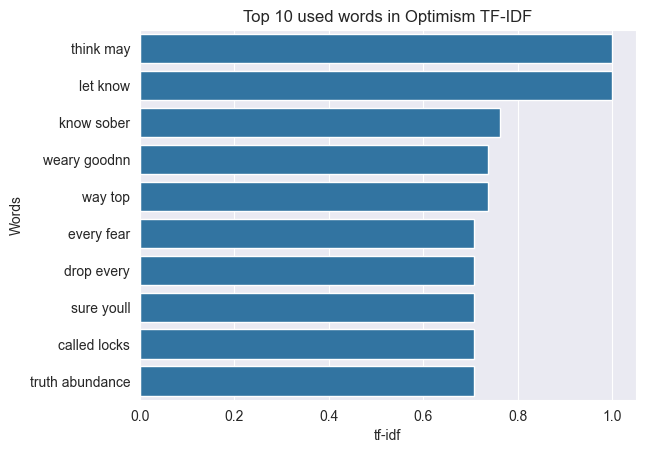

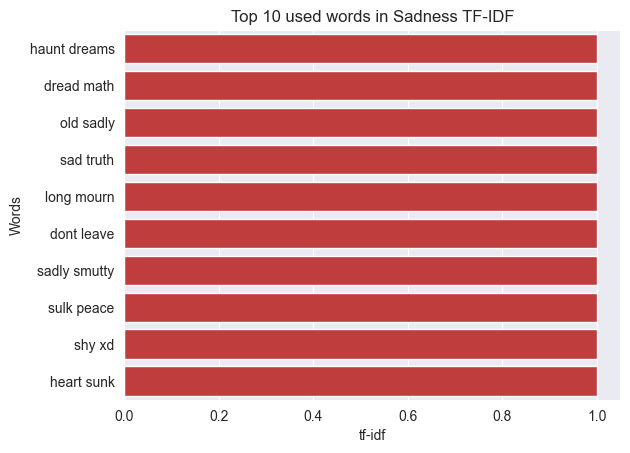

In [12]:
tfidf = TfidfVectorizer(ngram_range=(2, 2))
tfidf_matrix = tfidf.fit_transform(train_text['tokens_clean'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df['sentiment'] = train_labels["sentiment"]

most_common_words_tfidf = {}
top_n = 10
for sentiment in mapping.keys():
    sentiment_tokens = train_text[train_labels['sentiment'] == sentiment]['tokens_clean']
    
    top10_tfidf = get_top_tfidf_words(tfidf_df, sentiment, top_n=top_n)

    most_common_words_tfidf[mapping[sentiment]] = top10_tfidf
        
for sentiment, df in most_common_words_tfidf.items():
    sns.barplot(x='tf_idf', y='word', data=df, hue='word', palette=[palette[sentiment]] * top_n)
    
    plt.xlabel('tf-idf')
    plt.ylabel('Words')
    plt.title(f'Top {top_n} used words in {sentiment.capitalize()} TF-IDF')
    
    plt.show()

Unfortunately, we did not gain any relevant information. Most bigrams are not so relevant to capture the meaning of the relative topic.

# Calculate Flesch Readability Score

Again we try to find an index that can separate the classes from each other. In this case the Flesch index for readability. For the same reasoning as before: optimistic tweets we assume are written in a more readable language than anger tweets. This is because angerers usually write in a spur-of-the-moment manner, whereas for the other classes the message is more thoughtful.

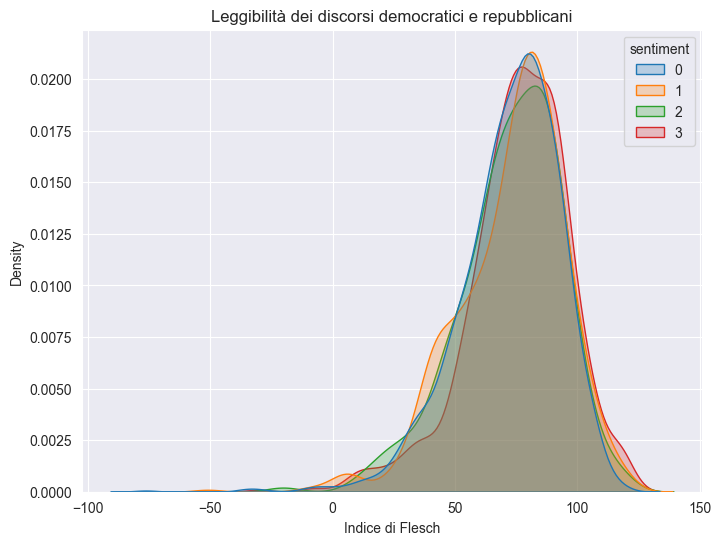

In [13]:
train_text['Flesch'] = train_text['text'].apply(flesch_reading_ease)
plt.figure(figsize=(8,6))
sns.kdeplot(data=train_text, x='Flesch', hue=train_labels['sentiment'], fill=True, 
            common_norm=False, palette=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.xlabel('Indice di Flesch')
plt.ylabel('Density')
plt.title('Leggibilità dei discorsi democratici e repubblicani')
plt.show()

There is no significant difference in peaks, although they are still at a different height. We will consider later whether to include this feature in the model to increase its predictive power.

Fancy wordcloud just for fun. It seems good to see graphs in predictive analysis.

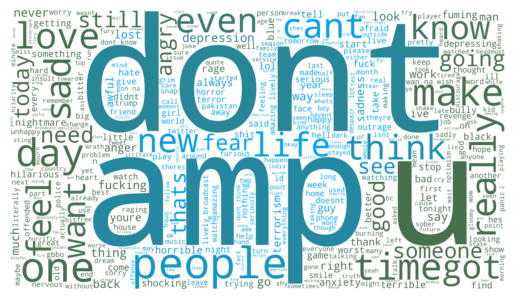

In [14]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import PIL.Image

try:
    big_string = ' '.join(train_text["tokens_clean"])
    twitter_mask = np.array(PIL.Image.open(os.path.join(os.getcwd(), "Twitter-Logo.png")).convert("RGB"))
    
    colormap = ImageColorGenerator(twitter_mask)
    
    wc = WordCloud(stopwords=set(list(STOPWORDS) + ["support"]),
                   mask=twitter_mask,
                   background_color="white",
                   contour_color="black",
                   contour_width=3,
                   min_font_size=3,
                   max_words=400,
                   ).generate(big_string)
    wc.recolor(color_func=colormap)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
except Exception:
    pass

# Data Preprocessing

In [44]:
from imblearn.over_sampling import SMOTE
from sentence_transformers import SentenceTransformer
from scipy.sparse import hstack, csr_matrix

We decided to use the 'all-mpnet-base-v2' embedded model, which is a sentence-transformers model that maps sentences and paragraphs to a 384-dimensional dense vector space. In this way we are able to better capture the semantic meaning of each sentence.

In [92]:
embedded_model = SentenceTransformer('all-mpnet-base-v2')

We created utility functions to help us with preprocessing. In particular:  

- get_sbert_embedding: The embedded model evaluates the text
- create_X_combined: Process our data by creating a matrix with all relevant features: we decide to include the number of chars, index readability, tf-idf and, of course, the model score. At the end we do data balancing with SMOTE. This is necessary because the size of one class is significantly larger than the others, so the resulting model wouldn't be able to distinguish the minority classes.

In [87]:
def get_sbert_embedding(text):
    return embedded_model.encode(text)

def create_X_combined(df, features_to_include: list, tfidf_vectorizer, do_sample: bool=False, is_pred: bool=False, i: int=0):
    
    df_n_chars = np.vstack(df['n_chars'].values)
    
    df_Flesch = np.vstack(df['Flesch'].values)
    
    df_embeddings = np.vstack(df['sbert_embedding'].values)
    
    tfidf_df = tfidf_vectorizer.transform(df['tokens_clean'])
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    
    df_embeddings_sparse = csr_matrix(df_embeddings)
    
    features_dict_df = {"tfidf": tfidf_df, "embeddings": df_embeddings_sparse,
                          "n_chars": df_n_chars, "flesch": df_Flesch}
    
    features_list_df = [features_dict_df[feature] for feature in features_to_include]
    
    feature_names = []
    features_list_df = []
    if "tfidf" in features_to_include:
        features_list_df.append(tfidf_df)
        feature_names.extend(tfidf_feature_names)
    if "embeddings" in features_to_include:
        features_list_df.append(df_embeddings_sparse)
        feature_names.extend([f'sbert_embedding_{i}' for i in range(df_embeddings.shape[1])])
    if "n_chars" in features_to_include:
        features_list_df.append(df_n_chars)
        feature_names.append('n_chars')
    if "flesch" in features_to_include:
        features_list_df.append(df_Flesch)
        feature_names.append('flesch')
    
    X_combined = hstack(features_list_df)
    
    if is_pred:
        return X_combined
    
    y_df = df['sentiment']
    
    if do_sample:
        smote = SMOTE(random_state=42+i)
        X_resampled, y_resampled = smote.fit_resample(X_combined, y_df)
        return X_resampled, y_resampled, feature_names
    
    return X_combined, y_df

# Reading, Cleaning and Preprocessing

For each txt file (train_text, val_text, test_text) we apply the following functions:
- slang replacement
- clean_txt function discussed before
- preprocess_txt function discussed before

Then we create some columns to calculate:
- n_chars per sentences
- Flesch index
- Embedded model score

In [93]:
train_text = read_txt(FILE_DIRECTORY, "train_text", delimiter=r"\n", columns=["text"])
train_labels = read_txt(FILE_DIRECTORY, "train_labels", delimiter=r"\n", columns=["sentiment"])

val_text = read_txt(FILE_DIRECTORY, "val_text", delimiter=r"\n", columns=["text"])
val_labels = read_txt(FILE_DIRECTORY, "val_labels", delimiter=r"\n", columns=["sentiment"])

train_text["text"] = train_text["text"].apply(lambda x: replace_slang(x, slang_dict))
val_text["text"] = val_text["text"].apply(lambda x: replace_slang(x, slang_dict))

train_text["clean_text"] = train_text["text"].apply(clean_txt)
train_text['tokens'] = train_text['clean_text'].apply(preprocess_txt)
train_text["sentiment"] = train_labels["sentiment"]

val_text["clean_text"] = val_text["text"].apply(clean_txt)
val_text['tokens'] = val_text['clean_text'].apply(preprocess_txt)
val_text["sentiment"] = val_labels["sentiment"]

train_text['tokens_clean'] = train_text['tokens'].apply(lambda tokens: ' '.join(tokens))
val_text['tokens_clean'] = val_text['tokens'].apply(lambda tokens: ' '.join(tokens))

train_text['n_chars'] = train_text['clean_text'].apply(len)
val_text['n_chars'] = val_text['clean_text'].apply(len)

train_text['Flesch'] = train_text['clean_text'].apply(flesch_reading_ease)
val_text['Flesch'] = val_text['clean_text'].apply(flesch_reading_ease)

train_text['sbert_embedding'] = train_text['clean_text'].apply(get_sbert_embedding)
val_text['sbert_embedding'] = val_text['clean_text'].apply(get_sbert_embedding)

test_text = read_txt(FILE_DIRECTORY, "test_text", delimiter=r"\n", columns=["text"])

test_text["clean_text"] = test_text["text"].apply(clean_txt)
test_text['tokens'] = test_text['clean_text'].apply(preprocess_txt)
test_text['tokens_clean'] = test_text['tokens'].apply(lambda tokens: ' '.join(tokens))

test_text['n_chars'] = test_text['clean_text'].apply(len)
test_text['Flesch'] = test_text['clean_text'].apply(flesch_reading_ease)

test_text['sbert_embedding'] = test_text['clean_text'].apply(get_sbert_embedding)

Once our data are ready, we create our matrices for traininig, testing and prediction. In particular, for each matrix, we put all togheter the "features_to_include". 

The choice to compute the td-idf score both for monogram and bigram is not casual. We noticed that if we consider just one group of them our F1 score decreases. 

In [94]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=3000)
tfidf_vectorizer.fit(train_text['tokens_clean'])

features_to_include = ["tfidf", "embeddings", "n_chars", "flesch"]

X_train_resampled, y_train_resampled, features_names = create_X_combined(train_text, features_to_include=features_to_include, 
                                                                         tfidf_vectorizer=tfidf_vectorizer, do_sample=True, i=0)
X_test_combined, y_test = create_X_combined(val_text, features_to_include=features_to_include, tfidf_vectorizer=tfidf_vectorizer)
prediction_df = create_X_combined(test_text, features_to_include=features_to_include, tfidf_vectorizer=tfidf_vectorizer, is_pred=True)

# Model Development

In [20]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

Initially, we conducted numerous trials with the RandomForestClassifier and GradientBoostingClassifier, but after several attempts, we decided to use LogisticRegression which give us an F1 score of 0.7105 according to the leaderbord. Afterwards we took the best models for each of our previous trials. The following strategy is to use a set of models trained on different samples of the starting dataset, so that the classes are balanced but the data in the training are different each time. Finally, these models are put together using a VotingClassifier in ‘soft’ mode, so that better performance can be achieved by giving more weight to the most important votes.

In [98]:
modelR = RandomForestClassifier(random_state=177, max_depth=60, max_features="log2", min_samples_split=12, n_estimators=800)
modelL = LogisticRegression(max_iter=6000, penalty="l2", solver="newton-cg", fit_intercept=True, warm_start=True)
modelG = GradientBoostingClassifier(random_state=177, n_estimators=800, max_features='log2', max_depth=8, learning_rate=0.008, subsample=0.8)

models = [modelR, modelL, modelG]
fitted_models = []

for index, model in enumerate(models):
    X_train_resampled, y_train_resampled, features_names = create_X_combined(train_text,
                                                                             features_to_include=features_to_include,
                                                                             tfidf_vectorizer=tfidf_vectorizer,
                                                                             do_sample=True, i=index) # The index is for different random_state
    model.fit(X_train_resampled, y_train_resampled)
    fitted_models.append((f'model_{index}', model))

voting_clf = VotingClassifier(estimators=fitted_models, voting='soft')
voting_clf.fit(X_train_resampled, y_train_resampled)

y_pred = voting_clf.predict(X_test_combined)
y_to_send = voting_clf.predict(prediction_df)
f1 = f1_score(y_test, y_pred, average="macro")
print(f"F1 Score on Test Data: {f1}")

y_to_send = voting_clf.predict(prediction_df)
y_to_send = pd.DataFrame(columns=["label"], data=y_to_send)
y_to_send.to_csv(os.path.join(os.getcwd(), 'predictions_78.csv'), index=False)

F1 Score on Test Data: 0.6737622455064315
